In [1]:
import sys
sys.path.append('/Users/evatakou/noise_est')

import stim
import numpy as np
from matplotlib import pyplot as plt

from sims.surface_code_bare_ancilla.circuit_SC import *
from estimation_funcs_surface_code import *
from utilities.utils_for_decoding import decode_both_dems_same_data
from construct_dem import *
from utilities.general_utils import avg_vi, avg_vivj_alt

import time


In [2]:
def get_DEM(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates):

    L             = distance
    num_ancilla   = L*(L-1)
    Reset         = True

    circuit    = planar_surface_code_circuit_X_memory(distance,num_rounds,p_depol_data,p_depol_anc,Reset,p_depol_after,depol_type_after_gates)

    if p_depol_data==0 and p_depol_anc==0 and p_depol_after==0:
        my_DEM = stim.DetectorErrorModel()
        return my_DEM,circuit
    
    # defects_matrix, data_qubit_samples = get_defects(circuit, distance,num_shots,num_rounds)

    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)

    start_time = time.time()


    vi_mean                        = avg_vi(defects_matrix)
    vivj_mean                      = avg_vivj_alt(defects_matrix.data)
    
    pij_time        = estimate_time_edge_probs(num_rounds,num_ancilla,vi_mean,vivj_mean)
    pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs(num_rounds,num_ancilla,distance,vi_mean,vivj_mean,pij_time)
    
    my_DEM = surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model())

    end_time = time.time()
    TIME = end_time-start_time

    return TIME





In [3]:
def get_DEM_alt(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates):

    L             = distance
    num_ancilla   = L*(L-1)
    Reset         = True

    circuit    = planar_surface_code_circuit_X_memory(distance,num_rounds,p_depol_data,p_depol_anc,Reset,p_depol_after,depol_type_after_gates)

    if p_depol_data==0 and p_depol_anc==0 and p_depol_after==0:
        my_DEM = stim.DetectorErrorModel()
        return my_DEM,circuit
    
    # defects_matrix, data_qubit_samples = get_defects(circuit, distance,num_shots,num_rounds)

    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)

    start_time = time.time()


    vi_mean                        = avg_vi(defects_matrix)
    # vivj_mean                      = avg_vivj_alt(defects_matrix.data)
    
    pij_time        = estimate_time_edge_probs_alt_V2(num_rounds,num_ancilla,defects_matrix,vi_mean)
    pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs_alt_Final(num_rounds,num_ancilla,distance,defects_matrix,pij_time,vi_mean)
    
    my_DEM = surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model())

    end_time = time.time()
    TIME = end_time-start_time

    return TIME





In [4]:
distance   = 11
num_rounds = 11
num_shots  = 10**5
p_depol_data = 0.01
p_depol_anc = 0.01
p_depol_after = 0.01
depol_type_after_gates = "DEPOLARIZE2"
num_ancilla   = distance*(distance-1)
Reset=True
# get_DEM(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates)

In [5]:

circuit    = planar_surface_code_circuit_X_memory(distance,num_rounds,p_depol_data,p_depol_anc,Reset,p_depol_after,depol_type_after_gates)



defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)



# vi_mean                        = avg_vi(defects_matrix)
# vivj_mean                      = avg_vivj_alt(defects_matrix.data)


# pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs_alt(num_rounds,num_ancilla,distance,defects_matrix,pij_time)


In [6]:
start_time = time.time()
pij_time        = estimate_time_edge_probs_alt(num_rounds,num_ancilla,defects_matrix)
end_time = time.time()
TIME = end_time-start_time
TIME

1.778493881225586

In [7]:
start_time = time.time()
pij_time_alt        = estimate_time_edge_probs_alt_V2(num_rounds,num_ancilla,defects_matrix)
end_time = time.time()
TIME = end_time-start_time
TIME

1.5502700805664062

In [8]:
for key in pij_time.keys():

    if pij_time[key]!=pij_time_alt[key]:
        raise Exception("Incorrect")

In [13]:
get_DEM_alt(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates)

8.033470869064331

In [5]:
from joblib import Parallel, delayed
import numpy as np

def calculate_runtime_parallel(distances, num_shots, iterMax, n_jobs=-1):
    
    p_depol_data = 0.01
    p_depol_anc = 0.01
    p_depol_after = 0.01
    depol_type_after_gates = "DEPOLARIZE2"
    TIMES = []
    std_error                   = []

    for distance in distances:
        # Parallel over iterations for each distance

        num_rounds = 3

        print(f"Processing distance: {distance}")
        avg_time = Parallel(n_jobs=n_jobs)(
            delayed(get_DEM_alt)(
                distance, num_rounds, num_shots,
                p_depol_data, p_depol_anc, p_depol_after,
                depol_type_after_gates
            )
            for _ in range(iterMax)
        )
        std_error.append(np.std(avg_time))
        TIMES.append(np.mean(avg_time))

    return TIMES,std_error


In [8]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib

def scaling_function(n, a, k):
    return a * n**k

def calculate_runtime(distances,num_shots,iterMax):

    
    p_depol_data           = 0.01
    p_depol_anc            = 0.01
    p_depol_after          = 0.01
    depol_type_after_gates = "DEPOLARIZE2"
    TIMES                  = []
    std_error                   = []

    for distance in distances:

        avg_time=[]
        
        for iter in range(iterMax):

            num_rounds = distance

            time = get_DEM_alt(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates)
            avg_time.append(time)

        std_error.append(np.std(avg_time))
        TIMES.append(np.mean(avg_time))
        

    return TIMES,std_error

max_d           = 19
distances       = np.arange(3,max_d+2,2)
num_shots       = 10**5
iterMax         = 400
TIMES,std_error = calculate_runtime_parallel(distances,num_shots,iterMax)

num_qubits = []
for distance in distances:

    num_qubits.append(distance**2 + (distance-1)**2 + distance*(distance-1))



Processing distance: 3
Processing distance: 5
Processing distance: 7
Processing distance: 9
Processing distance: 11
Processing distance: 13
Processing distance: 15
Processing distance: 17
Processing distance: 19


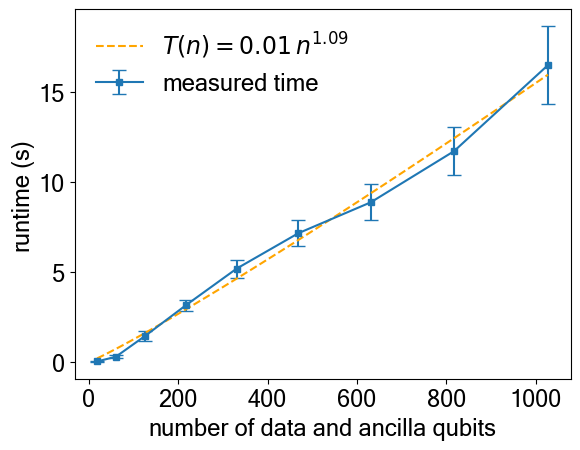

In [10]:
matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"

fig, ax = plt.subplots()
# plt.plot(num_qubits,TIMES,marker='o')
plt.errorbar(
    x=num_qubits,
    y=TIMES,
    yerr=std_error,
    xerr=None,
    fmt='-s',             # marker only (no line)
    label='measured time',
    color='tab:blue',
    capsize=5,
    markersize=5
)
# plt.errorbar(num_qubits, TIMES, yerr=std_error, fmt='-o', capsize=5, label='Measured runtimes')
plt.xlabel('number of data and ancilla qubits')
plt.ylabel('runtime (s)')
# plt.yscale('log')
# plt.ylim([0.1,1])

# Fit the scaling function to the data
popt, pcov = curve_fit(scaling_function, np.array(num_qubits), np.array(TIMES))

# # Plot the fitted curve
x_fit = np.linspace(min(num_qubits), max(num_qubits), 100)
y_fit = scaling_function(x_fit, *popt)

plt.plot(x_fit, y_fit, '--', label = f'$T(n) = {popt[0]:.2f} \\, n^{{{popt[1]:.2f}}}$',color='orange')
plt.legend(frameon=False)
# plt.ylim([-1,23])
plt.show()



# Print the fitted parameters (a, k)
# print(f"Empirical scaling: T(n) = {popt[0]:.2f} * n^{popt[1]:.2f}")

# fig.savefig("runtime_SC_code_repeat_200_N_10__5.pdf",bbox_inches='tight')
fig.savefig("new_runtime_400_averages.pdf",bbox_inches='tight')



In [23]:
popt

array([0.00424082, 1.22454609])

In [11]:
with open("average_time_400_repeat.txt", "w") as file:
    file.write(str(TIMES))
with open("std_error_time_400_repeat.txt", "w") as file:
    file.write(str(std_error))    
 